# ALeRCE: Classic Machine Learning vs Deep Learning

Authors: Guillermo Cabrera-Vives, Javier Arredondo, Ignacio Reyes

Partially based on: 
* https://github.com/alercebroker/usecases/blob/master/notebooks/ALeRCE_ML_Light_Curve_Classifier.ipynb

## Table of contents:
* [Required libraries](#Required-libraries)
* [Accessing ALeRCE Data](#Accessing-ALeRCE-Data)
    * [Query the ALeRCE DB for features](#Query-the-ALeRCE-DB-for-features)
* [Training set](#Training-set)
    * [Astro sanity check](#Astro-sanity-check)
* [Train a "classic" Random Forest](#Train-a-"classic"-Random-Forest)
* [Train a Balanced Random Forest](#Train-a-Balanced-Random-Forest)
    * [Feature importances](#Feature-importances)
* [Predicting on an unlabeled dataset](#Predicting-on-an-unlabeled-dataset)
* [Top level classifier](#Top-level-classifier)
    * [Comparison with the Recurrent Neural Network](#Comparison-with-the-Recurrent-Neural-Network)

## Required libraries

In [418]:
#!pip install alerce

In [419]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alerce.core import Alerce
import psycopg2
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

run_all = False

## Accessing ALeRCE Data

ALeRCE's database contains all the alerts generated by the Zwicky Transient Facility (ZTF) public stream. An alert is generated by ZTF each time an area of the sky is observed and a difference in brightness is detected. All alerts from the same coordinates are grouped into the same object with an object id (oid). Up to this date, the database contains more than 100 million alerts and 35 million objects.

Most ZTF detections come from two filters, g and r. Let's see an example of a light curve from ZTF.

In [420]:
alerce_client = Alerce()

In [421]:
def colormap(i):
    if i == 1:
        return '#56e03a'
    elif i == 2:
        return '#d42f4b'
    else:
        return '#000000'

def plot_light_curve(df, title='', period=None, apparent = False):
    for fid in df.fid.unique():
        fid_df = df[df.fid == fid]
        if len(fid_df) == 0:
            continue
        if apparent == True:
            mag = fid_df.magpsf_corr
            err = fid_df.sigmapsf_corr_ext
        else:
            mag = fid_df.magpsf
            err = fid_df.sigmapsf
        if period is not None:
            mjd = (fid_df.mjd % period) / period
            mjd = pd.concat((mjd, mjd+1))
            mag = pd.concat((mag, mag))
            err = pd.concat((err, err))
            print (mjd.shape, mag.shape, err.shape)
        else:
            mjd = fid_df.mjd
        plt.errorbar(mjd, mag, yerr=err,
            fmt='*', c=colormap(fid))
    plt.gca().invert_yaxis()
    if period is not None:
        plt.xlabel(f'Phase (period={period:.3f})')
    else:
        plt.xlabel('Date [mjd]')
    plt.ylabel('Apparent magnitude [mag]')
    plt.title(title)

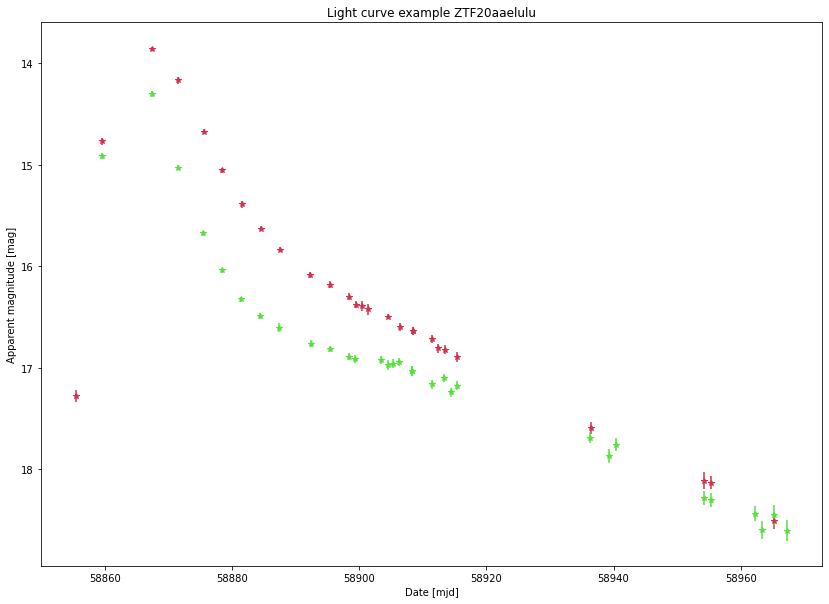

In [422]:
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
oid = 'ZTF20aaelulu'
light_curve = alerce_client.query_detections(oid, format='pandas')
plot_light_curve(light_curve, title=f'Light curve example {oid}')

### Query the ALeRCE DB for features

The ALeRCE database (ADB) contains  over 170 features calculated for each object. We will directly query the ADB and get those features out. We start by downloading the credentials file and connecting to the ADB.

In [423]:
!wget https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
credentials_file = "alercereaduser_v4.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
conn = psycopg2.connect(
    dbname=params['dbname'], 
    user=params['user'], 
    host=params['host'], 
    password=params['password'])

--2022-08-02 06:47:27--  https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
Resolving github.com (github.com)... 52.78.231.108
Connecting to github.com (github.com)|52.78.231.108|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json [following]
--2022-08-02 06:47:27--  https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156 [text/plain]
Saving to: ‘alercereaduser_v4.json.13’

alercereaduser_v4.j 100%[===================>]     156  --.-KB/s    in 0s      

2022-08-02 06:47:28 (1.79 MB/s) - ‘alercereaduser_v4.json.13’ saved [156/156]



As an example, we will use the object with object id (oid) 'ZTF19acelhxy'.

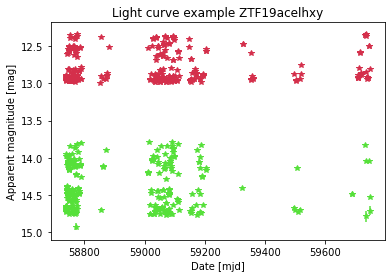

In [424]:
oid = "ZTF19acelhxy"
light_curve = alerce_client.query_detections(oid, format='pandas')
plot_light_curve(light_curve, title=f'Light curve example {oid}', apparent = True)

Query the ADB for all the features for that particular object

In [425]:
query = "select * from feature where oid='" + str(oid) + "';"
object_feat = pd.read_sql_query(query, conn)

In [426]:
object_feat


,oid,name,value,fid,version
0,ZTF19acelhxy,iqr,0.591698,1,lc_classifier_1.2.1-P
1,ZTF19acelhxy,iqr,0.349977,2,lc_classifier_1.2.1-P
2,ZTF19acelhxy,Amplitude,0.465350,1,lc_classifier_1.2.1-P
3,ZTF19acelhxy,AndersonDarling,1.000000,1,lc_classifier_1.2.1-P
4,ZTF19acelhxy,Autocor_length,1.000000,1,lc_classifier_1.2.1-P
...,...,...,...,...,...
173,ZTF19acelhxy,max_diffmaglim_after_fid,21.116800,1,lc_classifier_1.2.1-P
174,ZTF19acelhxy,max_diffmaglim_after_fid,20.914000,2,lc_classifier_1.2.1-P
175,ZTF19acelhxy,median_diffmaglim_after_fid,20.321150,2,lc_classifier_1.2.1-P
176,ZTF19acelhxy,SPM_A,6.454099,1,lc_classifier_1.2.1-P


In [427]:
period = object_feat[object_feat['name'] == "Multiband_period"]['value'].values[0]

In [428]:
period

3.799999864101415

Now, we fold and plot the light curve.

(546,) (546,) (546,)
(504,) (504,) (504,)


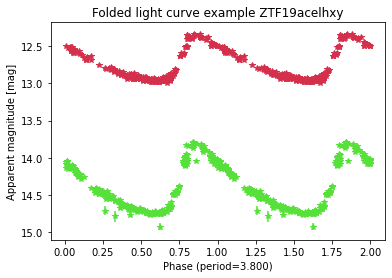

In [429]:
plot_light_curve(light_curve, title=f'Folded light curve example {oid}', period = period, apparent = True)

In the ALeRCE explorer: https://alerce.online/object/ZTF19acelhxy

## Training set

We will use the ALeRCE taxonomy and the ZTF labeled dataset described in Sánchez-Sáez et.al. 2021, AJ, 161, 141.

In [430]:
df_labels = pd.read_csv ("data/labeled_set_lc_classifier_SanchezSaez_2020.csv")

In [431]:
dict_top = {
    'LPV': "Periodic",
    'Periodic-Other': "Periodic", 
    'E': "Periodic",
    'DSCT': "Periodic",
    'RRL': "Periodic",
    'CEP': "Periodic",
    'SNIa': "Transient",
    'SNIbc': "Transient",
    'SNII': "Transient",
    'SLSN': "Transient",
    'CV/Nova': "Stochastic",
    'YSO': "Stochastic",   
    'AGN': "Stochastic",   
    'QSO': "Stochastic",   
    'Blazar': "Stochastic"    
}

df_labels['top_label'] = df_labels['classALeRCE'].map (dict_top)

In [432]:
df_labels.head()

,oid,classALeRCE,ra,dec,source,id_source,top_label
0,ZTF19aapcxhy,AGN,154.202129,18.723076,Oh2015,5.877420127343739e+17,Stochastic
1,ZTF18abtmwvo,AGN,46.074050,0.474212,Oh2015,5.880155098263717e+17,Stochastic
2,ZTF18acvgdfy,AGN,134.407409,5.472596,Oh2015,5.877327033915148e+17,Stochastic
3,ZTF19aabvjsi,AGN,132.353298,14.067266,Oh2015,5.877420137987442e+17,Stochastic
4,ZTF18aadyxlg,AGN,125.577004,33.091120,Oh2015,5.880133827239608e+17,Stochastic


In [433]:
for l in df_labels['top_label'].unique():
    print (df_labels['classALeRCE'][df_labels['top_label'] == l].value_counts())

QSO        26168
AGN         4667
YSO         1740
Blazar      1267
CV/Nova      871
Name: classALeRCE, dtype: int64
E                 37901
RRL               32482
LPV               14076
Periodic-Other     1256
DSCT                732
CEP                 618
Name: classALeRCE, dtype: int64
SNIa     1272
SNII      328
SNIbc      94
SLSN       24
Name: classALeRCE, dtype: int64


E                 37901
RRL               32482
QSO               26168
LPV               14076
AGN                4667
YSO                1740
SNIa               1272
Blazar             1267
Periodic-Other     1256
CV/Nova             871
DSCT                732
CEP                 618
SNII                328
SNIbc                94
SLSN                 24
Name: classALeRCE, dtype: int64


<AxesSubplot:>

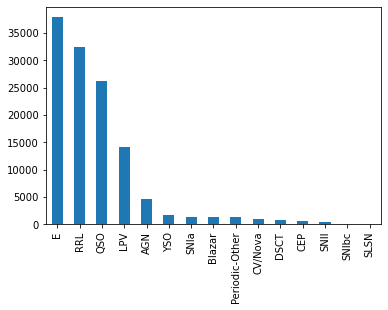

In [434]:
print (df_labels['classALeRCE'].value_counts())
df_labels['classALeRCE'].value_counts().plot(kind='bar')

In [435]:
labels = df_labels['classALeRCE'].unique()
print (labels)

['AGN' 'Blazar' 'CV/Nova' 'CEP' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'QSO'
 'RRL' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'YSO']


Select no more than 1000 per class.

In [436]:
# N_train = 1000
# df_train_ss = pd.DataFrame (columns = df_labels.columns)
# for l in labels:
#     df_lab = df_train[df_train['classALeRCE'] == l]
#     if df_lab.shape[0] <= N_train:
#         df_train_ss = pd.concat ((df_train_ss, df_lab))
#     else:
#         df_train_ss = pd.concat ((df_train_ss, df_lab.sample(N_train)))


Get the features from the ADB.

In [437]:
%%time
if run_all:
    # Select a test set of approximately 20% of the data.
    df_train, df_test = train_test_split(df_labels, test_size=0.2, random_state = 53)
    
    N_train = 10000
    df_train_ss = pd.DataFrame (columns = df_labels.columns)
    for l in labels:
        df_lab = df_train[df_train['classALeRCE'] == l]
        if df_lab.shape[0] <= N_train:
            df_train_ss = pd.concat ((df_train_ss, df_lab))
        else:
            df_train_ss = pd.concat ((df_train_ss, df_lab.sample(N_train)))

    base_query = """SELECT oid, CONCAT(name, fid) AS feature, value
    FROM feature  
    WHERE oid IN (%s)"""

    batch = pd.concat((df_train_ss["oid"], df_test["oid"])).values
    #batch = df_train_ss["oid"].values
    batch = [f"'{o}'" for o in batch]
    batch = ",".join(batch)

    query = base_query % batch

    df_features = pd.read_sql(query, conn)

    df_features.head()

    df_features = df_features.pivot_table(values='value', index="oid", columns='feature', aggfunc='first')

    df_features.to_parquet ("data/features_labels.parquet")
    df_test.to_parquet ("data/test_set.parquet")
    df_train.to_parquet ("data/train_set.parquet")
    df_train_ss.to_parquet ("data/train_set_ss.parquet")
else:
    df_features = pd.read_parquet("data/features_labels.parquet")
    df_test = pd.read_parquet ("data/test_set.parquet")
    df_train = pd.read_parquet ("data/train_set.parquet")
    df_train_ss = pd.read_parquet ("data/train_set_ss.parquet")
    

CPU times: user 297 ms, sys: 280 ms, total: 577 ms
Wall time: 1.01 s


In [438]:
df_train

,oid,classALeRCE,ra,dec,source,id_source
index,,,,,,
92770,ZTF18aakysaw,RRL,274.869590,31.218939,CRTSnorth,1132084008795.0
106738,ZTF18abtoutu,RRL,312.912021,27.341280,GAIADR2VS,1.8457372202271217e+18
41011,ZTF18abncene,E,347.503786,45.987589,ASASSN,ASASSN-V J231000.90+455915.4
86544,ZTF18acwykpr,QSO,162.059047,45.180550,MILLIQUAS,SDSS J104814.18+451050.0
35275,ZTF18aagsema,E,239.421055,32.564153,CRTSnorth,1132074038955.0
...,...,...,...,...,...,...
46843,ZTF19aaedwiw,LPV,220.092477,-17.657502,ASASSN,ASASSN-V J144022.21-173926.8
55717,ZTF18absrsqs,LPV,283.105035,-9.745349,GAIADR2VS,4.203198550853e+18
35701,ZTF18abcgtpm,E,335.532672,31.948581,CRTSnorth,1132103034121.0


In [439]:
if not "top_label" in df_train.columns:
    df_train = df_train.merge(df_labels[['oid', 'top_label']], how = "inner", right_on='oid', left_on='oid')
    df_train.to_parquet ("data/train_set.parquet")
if not "top_label" in df_train_ss.columns:
    df_train_ss = df_train_ss.merge(df_labels[['oid', 'top_label']], how = "inner", right_on='oid', left_on='oid')
    df_train_ss.to_parquet ("data/train_set_ss.parquet")
if not "top_label" in df_test.columns:
    df_test = df_test.merge(df_labels[['oid', 'top_label']], how = "inner", right_on='oid', left_on='oid')
    df_test.to_parquet ("data/test_set.parquet")

    #df_features = df_features.merge()

E                 7562
RRL               6550
QSO               5191
LPV               2758
AGN                969
YSO                340
SNIa               269
Blazar             265
Periodic-Other     259
CV/Nova            173
DSCT               148
CEP                123
SNII                70
SNIbc               18
SLSN                 5
Name: classALeRCE, dtype: int64


<AxesSubplot:title={'center':'Test set'}>

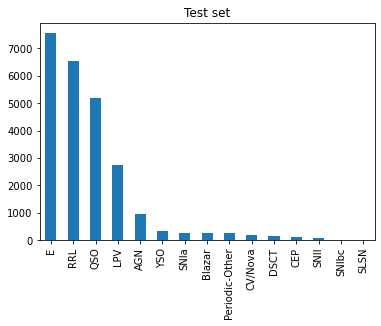

In [378]:
print (df_test['classALeRCE'].value_counts())
df_test['classALeRCE'].value_counts().plot(kind='bar', title = "Test set")

E                 30339
RRL               25932
QSO               20977
LPV               11318
AGN                3698
YSO                1400
SNIa               1003
Blazar             1002
Periodic-Other      997
CV/Nova             698
DSCT                584
CEP                 495
SNII                258
SNIbc                76
SLSN                 19
Name: classALeRCE, dtype: int64


<AxesSubplot:title={'center':'Training set'}>

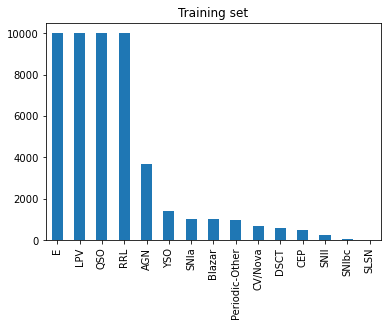

In [379]:
print (df_train['classALeRCE'].value_counts())
df_train_ss['classALeRCE'].value_counts().plot(kind='bar', title = "Training set")

In [380]:
print (df_features.shape, df_train_ss.shape, df_test.shape)

(74929, 179) (50230, 7) (24700, 7)


In [381]:
# Merge features and train and test set
df_train_ss = df_train_ss.merge(df_features, how = "inner", right_index=True, left_on='oid')
df_test     = df_test.merge(df_features, how = "inner", right_index=True, left_on='oid')


In [382]:
df_train_ss

,oid,classALeRCE,ra,dec,source,id_source,top_label,Amplitude1,Amplitude2,AndersonDarling1,...,n_non_det_before_fid1,n_non_det_before_fid2,n_pos1,n_pos2,positive_fraction1,positive_fraction2,r-W20,r-W30,rb0,sgscore10
0,ZTF18accnccu,AGN,112.662225,38.812311,Oh2015,5.87737825670267e+17,Stochastic,0.209880,0.103287,0.999966,...,8.0,2.0,143.0,103.0,1.000000,0.990385,5.075909,7.696910,0.952857,0.102202
1,ZTF19aauekza,AGN,329.434123,0.884357,MILLIQUAS,SDSS J215744.18+005303.6,Stochastic,0.406391,0.206137,1.000000,...,10.0,1.0,9.0,2.0,0.104651,0.025641,5.798734,8.313734,0.908571,0.046250
2,ZTF18absthpg,AGN,256.445546,63.183090,Oh2015,5.877254921340192e+17,Stochastic,0.311589,0.218946,1.000000,...,21.0,21.0,26.0,18.0,0.764706,0.947368,4.052014,7.185013,0.944286,0.015833
3,ZTF19aafdfxp,AGN,111.986359,39.991837,MILLIQUAS,SDSS J072756.72+395930.6,Stochastic,0.361658,0.268704,1.000000,...,5.0,6.0,35.0,25.0,0.729167,0.735294,5.534611,8.263611,0.935000,0.606199
4,ZTF19abdxwuy,AGN,324.194643,4.242673,MILLIQUAS,LAMOSTJ213646.70+041433.6,Stochastic,0.101632,0.138312,0.512400,...,8.0,5.0,0.0,0.0,0.000000,0.000000,5.685219,8.586219,0.940000,0.263792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50225,ZTF19aaptfpd,YSO,277.257278,0.496263,Simbad_variables,2MASS J18290174+0029463,Stochastic,0.707221,0.556616,0.988200,...,0.0,4.0,2.0,2.0,0.133333,0.074074,11.014544,13.134544,0.853572,0.500000
50226,ZTF18abfxrpq,YSO,277.378566,1.018622,Simbad_variables,2MASS J18293084+0101071,Stochastic,0.868946,0.544883,0.999592,...,11.0,0.0,14.0,8.0,0.341463,0.074074,7.908238,9.512238,0.882857,0.982500
50227,ZTF18acbzjuc,YSO,69.756815,23.600763,Simbad_variables,2MASS J04390163+2336029,Stochastic,0.083483,0.149011,1.000000,...,0.0,5.0,28.0,5.0,0.965517,0.714286,NaN,NaN,0.703333,0.987500
50228,ZTF19aasikdx,YSO,271.935685,-20.451707,Simbad_variables,2MASS J18074455-2027063,Stochastic,0.643650,0.399965,0.999933,...,10.0,3.0,4.0,18.0,0.200000,0.428571,NaN,NaN,0.840714,0.859821


### Astro sanity check

In [383]:
# Select Cepheids and RR Lyrae for exploring purposes
ceph = df_train_ss[df_train_ss['classALeRCE'] == "CEP"]
rrl = df_train_ss[df_train_ss['classALeRCE'] == "RRL"]

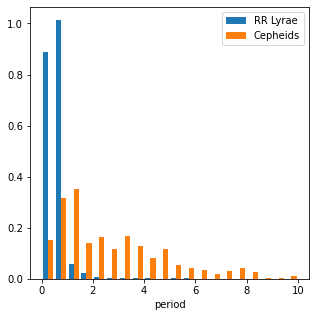

In [384]:
plt.figure(figsize = (5, 5))
plt.hist ((rrl['Multiband_period12'], ceph['Multiband_period12']), 
          label = ("RR Lyrae", "Cepheids"), bins = 20, range=(0, 10), 
          density = True)
plt.xlabel ("period")
plt.legend()

In [385]:
# Select Cepheids and RR Lyrae for exploring purposes
lpv = df_train_ss[df_train_ss['classALeRCE'] == "LPV"]
yso = df_train_ss[df_train_ss['classALeRCE'] == "YSO"]


Text(0, 0.5, 'galactic latitude')

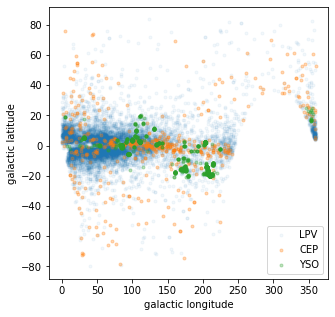

In [386]:
plt.figure(figsize = (5, 5))
plt.scatter (lpv['gal_l0'],lpv['gal_b0'], alpha = 0.05, marker = ".", label = "LPV")
plt.scatter (ceph['gal_l0'],ceph['gal_b0'], alpha = 0.3, marker = ".", label = "CEP")
plt.scatter (yso['gal_l0'],yso['gal_b0'], alpha = 0.3, marker = ".", label = "YSO")
plt.legend()
plt.xlabel("galactic longitude")
plt.ylabel("galactic latitude")

In [387]:
#QSO, AGN, blazar,
#SN Ia, SN Ibc, SN II, SLSN

qso = df_train_ss[df_train_ss['classALeRCE'] == "QSO"]
agn = df_train_ss[df_train_ss['classALeRCE'] == "AGN"]
blz = df_train_ss[df_train_ss['classALeRCE'] == "Blazar"]
SNe = df_train_ss[(df_train_ss['classALeRCE'] == "SNIa") | 
                  (df_train_ss['classALeRCE'] == "SNII") | 
                  (df_train_ss['classALeRCE'] == "SNIbc") | 
                  (df_train_ss['classALeRCE'] == "SLSN")]

Text(0, 0.5, 'galactic latitude')

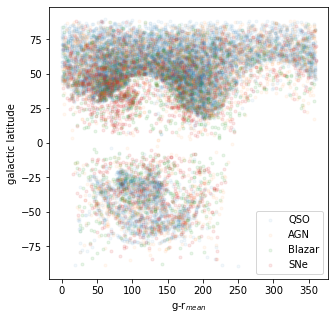

In [388]:
plt.figure(figsize = (5, 5))
plt.scatter (qso['gal_l0'],qso['gal_b0'], alpha = 0.05, marker = ".", label = "QSO")
plt.scatter (agn['gal_l0'],agn['gal_b0'], alpha = 0.05, marker = ".", label = "AGN")
plt.scatter (blz['gal_l0'],blz['gal_b0'], alpha = 0.1, marker = ".", label = "Blazar")
plt.scatter (SNe['gal_l0'],SNe['gal_b0'], alpha = 0.1, marker = ".", label = "SNe")
# plt.scatter (qso['g-r_mean12'],qso['gal_b0'], alpha = 0.05, marker = ".", label = "QSO")
# plt.scatter (agn['g-r_mean12'],agn['gal_b0'], alpha = 0.05, marker = ".", label = "AGN")
# plt.scatter (blz['g-r_mean12'],blz['gal_b0'], alpha = 0.1, marker = ".", label = "Blazar")
# plt.scatter (SNe['g-r_mean12'],SNe['gal_b0'], alpha = 0.1, marker = ".", label = "SNe")
plt.legend()
plt.xlabel(r"g-r$_{mean}$")
plt.ylabel("galactic latitude")

## Train a "classic" Random Forest

In [389]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection


In [390]:
# labels
y_train = df_train_ss['classALeRCE']

In [391]:
rm_feat = [
'oid',
'classALeRCE',
'top_label',
'ra',
'dec',
'source',
'id_source',
'MHPS_PN_flag1',
'MHPS_PN_flag2',
'MHPS_non_zero1',
'MHPS_non_zero2',
'first_mag1',
'first_mag2',
'last_mjd_before_fid1',
'last_mjd_before_fid2',
'mean_mag1',
'mean_mag2',
'min_mag1',
'min_mag2',
'n_det1',
'n_det2',
'n_neg1',
'n_neg2',
'n_pos1',
'n_pos2',
'iqr1',
'iqr2',
'delta_mjd_fid1',
'delta_mjd_fid2',
]

In [392]:
# features 
print("[", "',\n'".join(np.array(df_train_ss.columns)), "]")

[ oid',
'classALeRCE',
'ra',
'dec',
'source',
'id_source',
'top_label',
'Amplitude1',
'Amplitude2',
'AndersonDarling1',
'AndersonDarling2',
'Autocor_length1',
'Autocor_length2',
'Beyond1Std1',
'Beyond1Std2',
'Con1',
'Con2',
'Eta_e1',
'Eta_e2',
'ExcessVar1',
'ExcessVar2',
'GP_DRW_sigma1',
'GP_DRW_sigma2',
'GP_DRW_tau1',
'GP_DRW_tau2',
'Gskew1',
'Gskew2',
'Harmonics_mag_11',
'Harmonics_mag_12',
'Harmonics_mag_21',
'Harmonics_mag_22',
'Harmonics_mag_31',
'Harmonics_mag_32',
'Harmonics_mag_41',
'Harmonics_mag_42',
'Harmonics_mag_51',
'Harmonics_mag_52',
'Harmonics_mag_61',
'Harmonics_mag_62',
'Harmonics_mag_71',
'Harmonics_mag_72',
'Harmonics_mse1',
'Harmonics_mse2',
'Harmonics_phase_21',
'Harmonics_phase_22',
'Harmonics_phase_31',
'Harmonics_phase_32',
'Harmonics_phase_41',
'Harmonics_phase_42',
'Harmonics_phase_51',
'Harmonics_phase_52',
'Harmonics_phase_61',
'Harmonics_phase_62',
'Harmonics_phase_71',
'Harmonics_phase_72',
'IAR_phi1',
'IAR_phi2',
'LinearTrend1',
'LinearTrend2',
'MHPS_PN

In [393]:
x_train = df_train_ss.drop(rm_feat, axis=1).replace([np.inf, -np.inf], np.nan).fillna(-999)
x_train[x_train > 1e6] = 1e6

In [394]:
i_sample = np.random.choice (np.arange (x_train.shape[0]), 10000)

In [395]:
# labels_foo = ["E", "LPV", "QSO"]
# print (labels)
# for i in range (1, len(labels_foo)):
#     lab_ss = labels_foo[:i+1]
#     i_sample = y_train == lab_ss[0]
#     for l in lab_ss[1:]:
#         i_sample = i_sample | (y_train == l)
#     print (y_train.loc[i_sample].value_counts())
#     clf = RandomForestClassifier()
#     #clf.fit (x_train.loc[i_sample], y_train.loc[i_sample])
#     ss = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.5)
#     scores = model_selection.cross_val_score(clf, x_train.loc[i_sample], y_train.loc[i_sample], cv=ss)
#     print ("scores = ", scores)

In [396]:
clf = RandomForestClassifier()
ss = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.5)
scores = model_selection.cross_val_score(clf, x_train, y_train, cv=ss)
print ("Accuracy = ", scores.mean(), "+-", scores.std())

Accuracy =  0.9159307186940076 +- 0.0010926368424790862


In [100]:
scores

array([0.91558829, 0.91288075, 0.91534939, 0.91718097, 0.91530958])

In [101]:
print (x_train.shape, y_train.shape)


(50229, 157) (50229,)


In [105]:
N_val = 100
Ns = np.concatenate([2**np.arange(5, 16), [x_train.shape[0] - N_val]])

scores = np.zeros(len(Ns))
stds = np.zeros(len(Ns))
for i in range(len(Ns)):
    print (i, Ns[i])
    N = Ns[i]
    ss = model_selection.StratifiedShuffleSplit(n_splits=10, test_size = N_val, train_size = N)
    scores_i = model_selection.cross_val_score(clf, x_train, y_train, cv=ss)
    scores[i] = scores_i.mean()
    print (i, Ns[i], scores[i])
    stds[i] = scores_i.std()



0 32
0 32 0.679
1 64
1 64 0.7289999999999999
2 128
2 128 0.789
3 256
3 256 0.796
4 512
4 512 0.841
5 1024
5 1024 0.8619999999999999
6 2048
6 2048 0.8869999999999999
7 4096
7 4096 0.8969999999999999
8 8192
8 8192 0.917
9 16384
9 16384 0.923
10 32768
10 32768 0.917
11 50129
11 50129 0.9199999999999999


<Figure size 432x288 with 0 Axes>

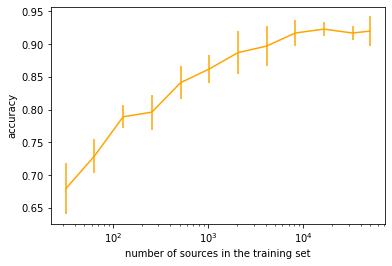

In [188]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar (Ns, scores, yerr = stds, c = "orange")
ax.set_xscale("log")
ax.set_xlabel("number of sources in the training set")
ax.set_ylabel("accuracy")
plt.show()

In [112]:
from sklearn.model_selection import GridSearchCV

N_val = 100

param_grid = dict(n_estimators = [10, 100, 1000])
ss = model_selection.StratifiedShuffleSplit(n_splits=10, test_size = N_val, train_size = N)
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv = ss)
grid.fit (x_train, y_train)

KeyboardInterrupt: 

In [397]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [398]:
# train a single Random Forest with all the data

model_RF = RandomForestClassifier ()
model_RF.fit(x_train, y_train)

RandomForestClassifier()

In [399]:
# Test on the labeled test_set

y_test = df_test['classALeRCE']
x_test = df_test.drop(rm_feat, axis=1).replace([np.inf, -np.inf], np.nan).fillna(-999)
x_test[x_test > 1e6] = 1e6


In [400]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from visual import plot_confusion_matrix


In [401]:
y_pred_RF = model_RF.predict (x_test)

acc_test = accuracy_score(y_test, y_pred_RF)

print ("accuracy = ", acc_test)

f1_test = f1_score(y_test, y_pred_RF, average = "weighted")

print ("f1 = ", f1_test)


accuracy =  0.9422672064777328
f1 =  0.9400716310580971


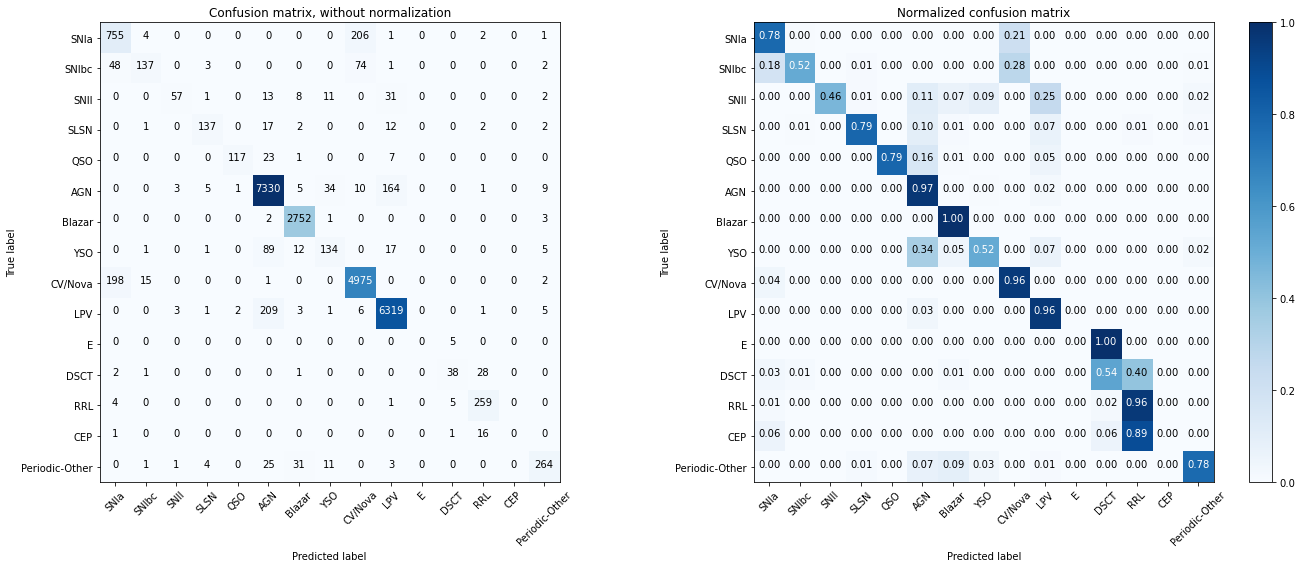

In [402]:
label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']
class_names = label_order
cnf_matrix = confusion_matrix(y_test, y_pred_RF)
# Plot non-normalized confusion matrix
plt.figure(figsize=(20,8))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

## Train a Balanced Random Forest

In [127]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [133]:
%%time
model_BRF = BalancedRandomForestClassifier (
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

model_BRF.fit(x_train, y_train)

CPU times: user 9.11 s, sys: 1.22 s, total: 10.3 s
Wall time: 4.75 s


BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               criterion='entropy', n_estimators=500,
                               n_jobs=-1)

In [140]:
y_pred_BRF = model_BRF.predict (x_test)

acc_test = accuracy_score(y_test, y_pred)

print ("accuracy = ", acc_test)

f1_test = f1_score(y_test, y_pred, average = "macro")

print ("f1 = ", f1_test)

accuracy =  0.8001214574898785
f1 =  0.5446747196031807


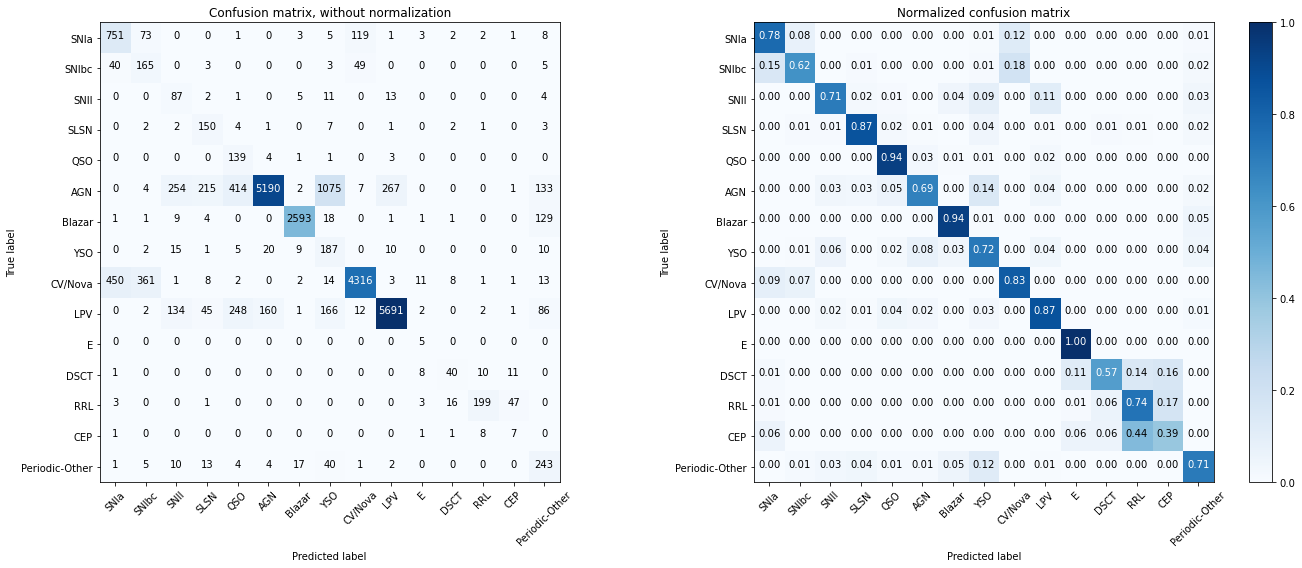

In [141]:
class_names = label_order
cnf_matrix = confusion_matrix(y_test, y_pred_BRF)
# Plot non-normalized confusion matrix
plt.figure(figsize=(20,8))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

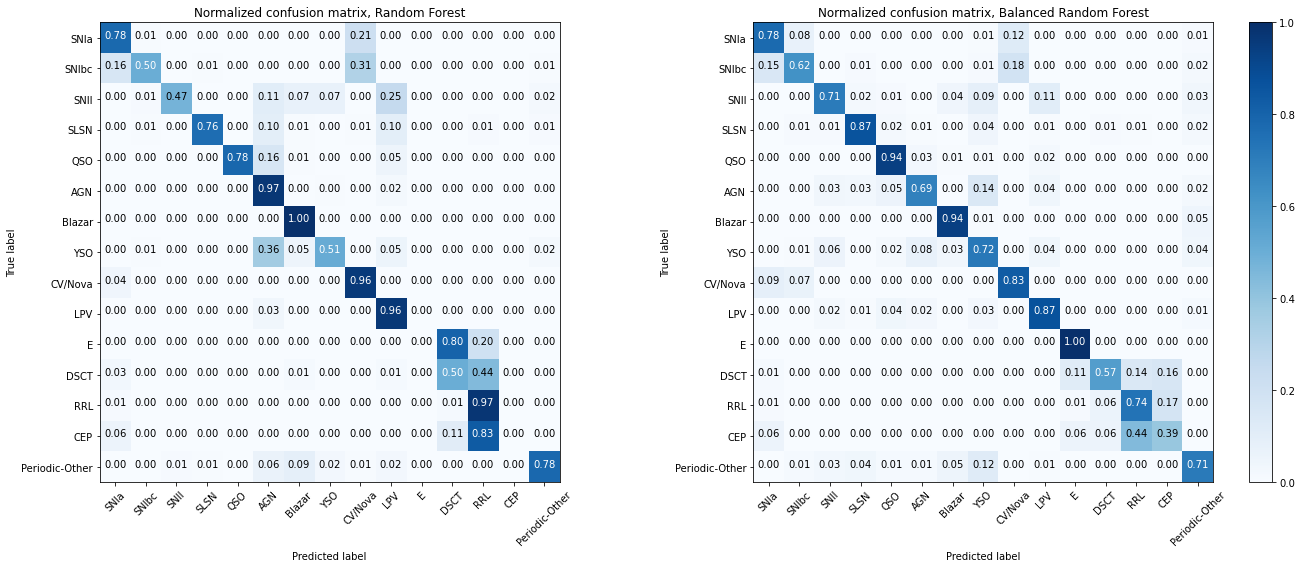

In [144]:
# Plot RF normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_RF)
plt.figure(figsize=(20,8))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

# Plot BRF normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_BRF)
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Balanced Random Forest')

### Feature importances

In [289]:
# plot feature importances
def plot_feature_importances(model, feature_names, title):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.title (title)
    plt.show()
    #plt.close()

In [290]:
x_train.columns

Index(['Amplitude1', 'Amplitude2', 'AndersonDarling1', 'AndersonDarling2',
       'Autocor_length1', 'Autocor_length2', 'Beyond1Std1', 'Beyond1Std2',
       'Con1', 'Con2',
       ...
       'n_non_det_after_fid1', 'n_non_det_after_fid2', 'n_non_det_before_fid1',
       'n_non_det_before_fid2', 'positive_fraction1', 'positive_fraction2',
       'r-W20', 'r-W30', 'rb0', 'sgscore10'],
      dtype='object', length=157)

g-W20 & 0.047
W1-W20 & 0.044
g-r_max12 & 0.037
Multiband_period12 & 0.036
r-W20 & 0.034
g-r_mean12 & 0.031
g-W30 & 0.030
Period_band1 & 0.026
g-r_mean_corr12 & 0.026
g-r_max_corr12 & 0.026
r-W30 & 0.024
sgscore10 & 0.024
IAR_phi1 & 0.023
Period_band2 & 0.021
MHPS_high1 & 0.017
W2-W30 & 0.017
SPM_A2 & 0.017
MHPS_ratio1 & 0.016
ExcessVar1 & 0.015
Mean2 & 0.014
GP_DRW_tau2 & 0.013
Std1 & 0.012
MHPS_low1 & 0.012
SPM_A1 & 0.011
GP_DRW_tau1 & 0.011
Gskew1 & 0.010
IAR_phi2 & 0.010
SPM_chi2 & 0.009
GP_DRW_sigma1 & 0.009
Autocor_length1 & 0.009


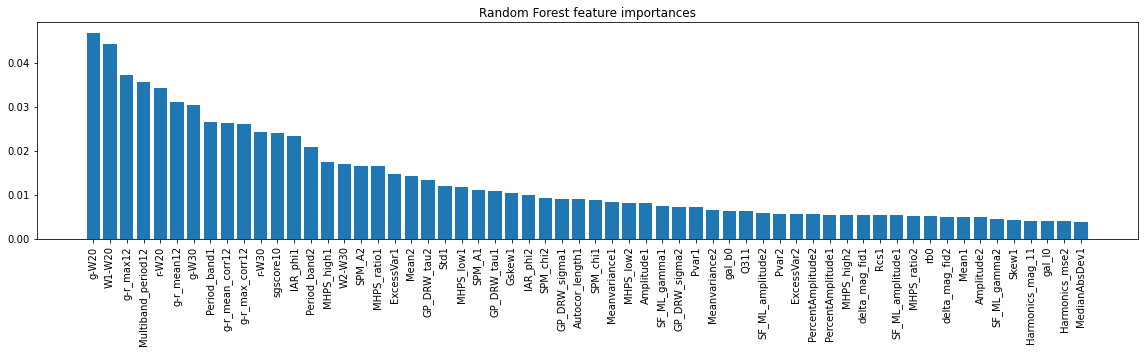

In [291]:
plot_feature_importances (model_RF, x_train.columns, "Random Forest feature importances")

W1-W20 & 0.029
g-W20 & 0.028
g-W30 & 0.026
r-W30 & 0.026
r-W20 & 0.025
IAR_phi2 & 0.020
SPM_chi2 & 0.020
sgscore10 & 0.019
Multiband_period12 & 0.018
positive_fraction1 & 0.017
IAR_phi1 & 0.017
SPM_chi1 & 0.016
W2-W30 & 0.016
Period_band1 & 0.016
Mean2 & 0.016
g-r_mean12 & 0.015
positive_fraction2 & 0.015
GP_DRW_tau2 & 0.015
n_non_det_after_fid2 & 0.014
GP_DRW_tau1 & 0.014
g-r_max12 & 0.013
g-r_max_corr12 & 0.013
g-r_mean_corr12 & 0.012
SPM_tau_rise1 & 0.011
Period_band2 & 0.010
LinearTrend2 & 0.010
Rcs2 & 0.010
MHPS_high1 & 0.010
SPM_tau_rise2 & 0.010
SF_ML_amplitude2 & 0.009


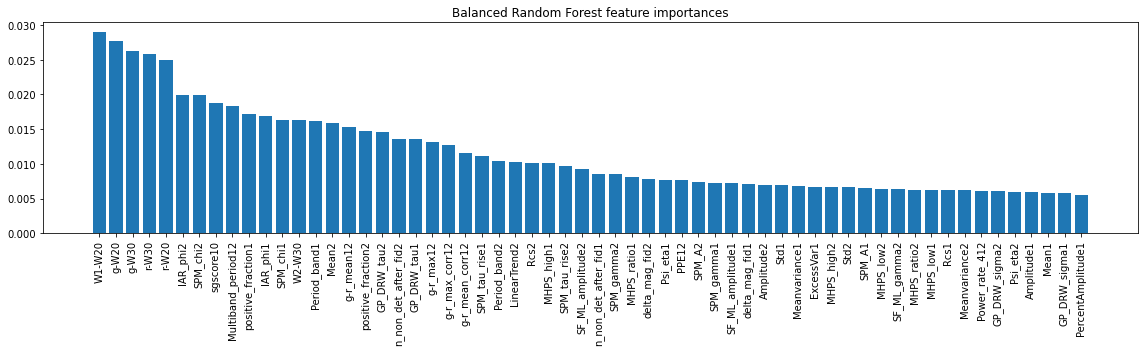

In [292]:
plot_feature_importances (model_BRF, x_train.columns, "Balanced Random Forest feature importances")

## Predicting on an unlabeled dataset

In [200]:
run_all = False

# Random unlabeled dataset from Sánchez-Sáez 2021
df_unlabeled = pd.read_csv ("data/ALeRCE_lc_classifier_outputs_ZTF_unlabeled_set_20200609.csv")


In [201]:
df_unlabeled.head()

,oid,ra,dec,Transient_prob_top,Stochastic_prob_top,Periodic_prob_top,SNIa_prob_T,SNIbc_prob_T,SNII_prob_T,SLSN_prob_T,...,YSO_prob,CV/Nova_prob,LPV_prob,E_prob,DSCT_prob,RRL_prob,CEP_prob,Periodic-Other_prob,predicted_class,predicted_class_proba
0,ZTF17aaaaavn,316.742953,49.138344,0.016,0.308,0.676,0.138,0.230,0.302,0.330,...,0.218064,0.045584,0.021632,0.156832,0.018928,0.012168,0.036504,0.429936,Periodic-Other,0.429936
1,ZTF17aaaadjh,75.806810,50.116662,0.000,0.014,0.986,0.130,0.174,0.242,0.454,...,0.001820,0.011844,0.003944,0.658648,0.025636,0.153816,0.096628,0.047328,E,0.658648
2,ZTF17aaaadwo,319.101209,44.968602,0.002,0.124,0.874,0.152,0.228,0.280,0.340,...,0.084320,0.034472,0.013984,0.213256,0.019228,0.022724,0.075164,0.529644,Periodic-Other,0.529644
3,ZTF17aaaajjv,321.297602,47.345766,0.004,0.020,0.976,0.090,0.156,0.224,0.530,...,0.017480,0.000480,0.974048,0.000000,0.000000,0.000000,0.001952,0.000000,LPV,0.974048
4,ZTF17aaaakjt,53.405642,50.727601,0.000,0.036,0.964,0.202,0.246,0.294,0.258,...,0.023040,0.011520,0.009640,0.485856,0.023136,0.117608,0.246784,0.080976,E,0.485856


In [213]:
df_unlabeled_ss_ids = df_unlabeled[['oid']].sample(10000)

In [214]:
df_unlabeled_ss_ids.head()

,oid
218907,ZTF18absygks
289727,ZTF18aaakvpg
650067,ZTF18abmexqq
610507,ZTF19aaaezky
469529,ZTF17aaayqnp


In [215]:
if run_all:
    !wget https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
    credentials_file = "alercereaduser_v4.json"
    with open(credentials_file) as jsonfile:
        params = json.load(jsonfile)["params"]
    conn = psycopg2.connect(
        dbname=params['dbname'], 
        user=params['user'], 
        host=params['host'], 
        password=params['password'])

--2022-08-01 20:19:21--  https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
Resolving github.com (github.com)... 20.200.245.247
Connecting to github.com (github.com)|20.200.245.247|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json [following]
--2022-08-01 20:19:21--  https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156 [text/plain]
Saving to: ‘alercereaduser_v4.json.10’

alercereaduser_v4.j 100%[===================>]     156  --.-KB/s    in 0s      

2022-08-01 20:19:21 (11.4 MB/s) - ‘alercereaduser_v4.json.10’ saved [156/156]



In [216]:
%%time
if run_all:
    base_query = """SELECT oid, CONCAT(name, fid) AS feature, value
    FROM feature  
    WHERE oid IN (%s)"""

    batch = df_unlabeled_ss_ids["oid"].values
    batch = [f"'{o}'" for o in batch]
    batch = ",".join(batch)

    query = base_query % batch

    df_unlab_feat = pd.read_sql(query, conn)

    df_unlab_feat.head()

    df_unlab_feat = df_unlab_feat.pivot_table(values='value', index="oid", columns='feature', aggfunc='first')

    df_unlab_feat.to_parquet ("data/unlabeled_features.parquet")
else:
    df_unlab_feat = pd.read_parquet("data/unlabeled_features.parquet")


CPU times: user 4.21 s, sys: 5.18 s, total: 9.4 s
Wall time: 1min 54s


In [217]:
df_unlab_feat.shape

(10000, 179)

In [218]:
df_unlab_feat.head()

feature,Amplitude1,Amplitude2,AndersonDarling1,AndersonDarling2,Autocor_length1,Autocor_length2,Beyond1Std1,Beyond1Std2,Con1,Con2,...,n_non_det_before_fid1,n_non_det_before_fid2,n_pos1,n_pos2,positive_fraction1,positive_fraction2,r-W20,r-W30,rb0,sgscore10
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaace,0.370890,0.379529,1.000000,1.0,1.0,1.0,0.383721,0.352941,0.0,0.0,...,1.0,4.0,5.0,14.0,0.058140,0.137255,2.561678,4.727678,0.885000,0.972667
ZTF17aaaaaup,0.079382,NaN,0.631212,NaN,1.0,NaN,0.230769,NaN,0.0,NaN,...,4.0,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,0.801429,0.990625
ZTF17aaaabsi,0.360050,0.353629,1.000000,1.0,1.0,1.0,0.321212,0.367347,0.0,0.0,...,0.0,0.0,106.0,40.0,0.642424,0.272109,1.944196,4.803196,0.909286,0.982167
ZTF17aaaaebr,0.255647,0.208766,1.000000,1.0,1.0,1.0,0.400000,0.205479,0.0,0.0,...,1.0,8.0,4.0,5.0,0.100000,0.068493,3.530161,4.641161,0.716667,0.997083
ZTF17aaaaffh,0.280118,0.248779,1.000000,1.0,1.0,1.0,0.494624,0.400000,0.0,0.0,...,2.0,9.0,15.0,6.0,0.161290,0.133333,3.418411,5.295410,0.725000,0.999167


In [221]:
rm_feat_unlab = [
'MHPS_PN_flag1',
'MHPS_PN_flag2',
'MHPS_non_zero1',
'MHPS_non_zero2',
'first_mag1',
'first_mag2',
'last_mjd_before_fid1',
'last_mjd_before_fid2',
'mean_mag1',
'mean_mag2',
'min_mag1',
'min_mag2',
'n_det1',
'n_det2',
'n_neg1',
'n_neg2',
'n_pos1',
'n_pos2',
'iqr1',
'iqr2',
'delta_mjd_fid1',
'delta_mjd_fid2',
]

x_unlab = df_unlab_feat.drop(rm_feat_unlab, axis=1).replace([np.inf, -np.inf], np.nan).fillna(-999)
x_unlab[x_unlab > 1e6] = 1e6

In [231]:
# Predict

y_pred_unlab_BRF = model_BRF.predict (x_unlab)
y_pbb_unlab_BRF = model_BRF.predict_proba (x_unlab)

In [236]:
y_pbb_unlab_BRF.max(axis = 1).shape

(10000,)

In [237]:
df_unlab_feat['predict'] = y_pred_unlab_BRF
df_unlab_feat['predict_pbb'] = y_pbb_unlab_BRF.max(axis = 1)

In [238]:
df_unlab_feat['predict'].value_counts()

Periodic-Other    3282
E                 1800
LPV               1438
YSO               1340
RRL                645
QSO                515
DSCT               336
CEP                198
CV/Nova            159
AGN                147
Blazar              67
SNIa                36
SNIbc               14
SNII                13
SLSN                10
Name: predict, dtype: int64

In [248]:
df_unlab_feat['predict_pbb'].describe()

count    10000.000000
mean         0.334876
std          0.120215
min          0.106000
25%          0.247500
50%          0.314000
75%          0.402000
max          0.804000
Name: predict_pbb, dtype: float64

In [267]:
cep_un = df_unlab_feat[df_unlab_feat['predict'] == "CEP"]
rrl_un = df_unlab_feat[df_unlab_feat['predict'] == "RRL"]


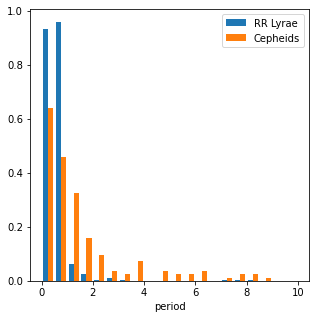

In [268]:
plt.figure(figsize = (5, 5))
plt.hist ((rrl_un['Multiband_period12'], cep_un['Multiband_period12']), 
          label = ("RR Lyrae", "Cepheids"), bins = 20, range=(0, 10), 
          density = True)
plt.xlabel ("period")
plt.legend()

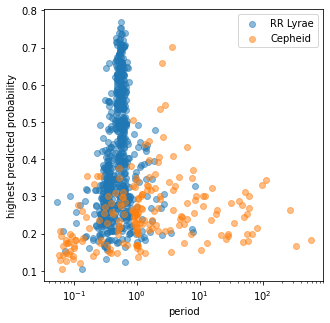

In [279]:
plt.figure(figsize = (5, 5))
plt.scatter (rrl_un['Multiband_period12'], rrl_un['predict_pbb'], 
              label = "RR Lyrae", alpha = 0.5)
plt.scatter (cep_un['Multiband_period12'], cep_un['predict_pbb'], 
              label = "Cepheid", alpha = 0.5)
plt.xlabel ("period")
plt.ylabel ("highest predicted probability")
plt.xscale("log")
plt.legend()

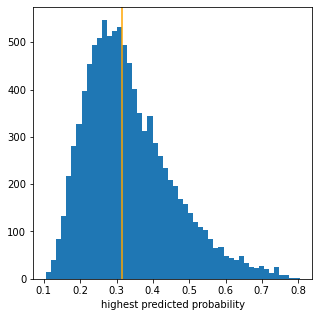

In [277]:
plt.figure(figsize = (5, 5))
plt.hist (df_unlab_feat['predict_pbb'], bins = 50)
plt.xlabel ("highest predicted probability")
plt.axvline(0.314000, c = "orange")

In [250]:
df_unlab_certain = df_unlab_feat[df_unlab_feat['predict_pbb'] >= 0.314]
df_unlab_certain['predict'].value_counts()

Periodic-Other    1495
E                 1079
LPV                983
QSO                431
RRL                416
YSO                249
AGN                109
DSCT                84
CV/Nova             63
CEP                 40
Blazar              35
SNIa                16
SNIbc                3
SNII                 2
SLSN                 1
Name: predict, dtype: int64

In [251]:
# cep_un = df_unlab_feat[df_unlab_feat['predict'] == "CEP"]
# rrl_un = df_unlab_feat[df_unlab_feat['predict'] == "RRL"]
# lpv_un = df_unlab_feat[df_unlab_feat['predict'] == "LPV"]
# yso_un = df_unlab_feat[df_unlab_feat['predict'] == "YSO"]
# qso_un = df_unlab_feat[df_unlab_feat['predict'] == "QSO"]
# agn_un = df_unlab_feat[df_unlab_feat['predict'] == "AGN"]
# blz_un = df_unlab_feat[df_unlab_feat['predict'] == "Blazar"]
# SNe_un = df_unlab_feat[(df_unlab_feat['predict'] == "SNIa") | 
#                     (df_unlab_feat['predict'] == "SNII") | 
#                     (df_unlab_feat['predict'] == "SNIbc") | 
#                     (df_unlab_feat['predict'] == "SLSN")]

In [253]:
cep_un = df_unlab_certain[df_unlab_certain['predict'] == "CEP"]
rrl_un = df_unlab_certain[df_unlab_certain['predict'] == "RRL"]
lpv_un = df_unlab_certain[df_unlab_certain['predict'] == "LPV"]
yso_un = df_unlab_certain[df_unlab_certain['predict'] == "YSO"]
qso_un = df_unlab_certain[df_unlab_certain['predict'] == "QSO"]
agn_un = df_unlab_certain[df_unlab_certain['predict'] == "AGN"]
blz_un = df_unlab_certain[df_unlab_certain['predict'] == "Blazar"]
SNe_un = df_unlab_certain[(df_unlab_certain['predict'] == "SNIa") | 
                    (df_unlab_certain['predict'] == "SNII") | 
                    (df_unlab_certain['predict'] == "SNIbc") | 
                    (df_unlab_certain['predict'] == "SLSN")]

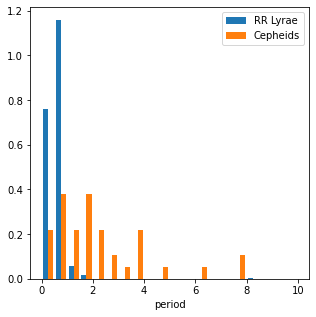

In [254]:
plt.figure(figsize = (5, 5))
plt.hist ((rrl_un['Multiband_period12'], cep_un['Multiband_period12']), 
          label = ("RR Lyrae", "Cepheids"), bins = 20, range=(0, 10), 
          density = True)
plt.xlabel ("period")
plt.legend()

Text(0, 0.5, 'galactic latitude')

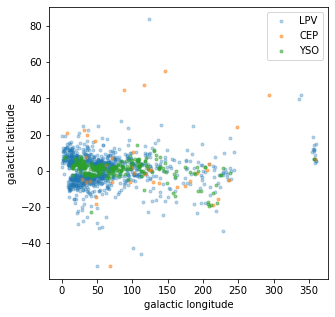

In [258]:
plt.figure(figsize = (5, 5))
plt.scatter (lpv_un['gal_l0'],lpv_un['gal_b0'], alpha = 0.3, marker = ".", label = "LPV")
plt.scatter (cep_un['gal_l0'],cep_un['gal_b0'], alpha = 0.5, marker = ".", label = "CEP")
plt.scatter (yso_un['gal_l0'],yso_un['gal_b0'], alpha = 0.5, marker = ".", label = "YSO")
plt.legend()
plt.xlabel("galactic longitude")
plt.ylabel("galactic latitude")

Text(0, 0.5, 'galactic latitude')

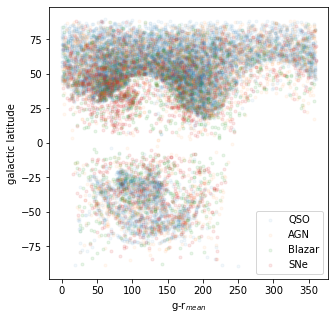

In [259]:
plt.figure(figsize = (5, 5))
plt.scatter (qso['gal_l0'],qso['gal_b0'], alpha = 0.05, marker = ".", label = "QSO")
plt.scatter (agn['gal_l0'],agn['gal_b0'], alpha = 0.05, marker = ".", label = "AGN")
plt.scatter (blz['gal_l0'],blz['gal_b0'], alpha = 0.1, marker = ".", label = "Blazar")
plt.scatter (SNe['gal_l0'],SNe['gal_b0'], alpha = 0.1, marker = ".", label = "SNe")
# plt.scatter (qso['g-r_mean12'],qso['gal_b0'], alpha = 0.05, marker = ".", label = "QSO")
# plt.scatter (agn['g-r_mean12'],agn['gal_b0'], alpha = 0.05, marker = ".", label = "AGN")
# plt.scatter (blz['g-r_mean12'],blz['gal_b0'], alpha = 0.1, marker = ".", label = "Blazar")
# plt.scatter (SNe['g-r_mean12'],SNe['gal_b0'], alpha = 0.1, marker = ".", label = "SNe")
plt.legend()
plt.xlabel(r"g-r$_{mean}$")
plt.ylabel("galactic latitude")

## Top level classifier

In [410]:
y_train_top = df_train_ss['top_label']
y_test_top = df_test['top_label']


In [413]:
%%time
model_top = BalancedRandomForestClassifier (
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

model_top.fit(x_train, y_train_top)

CPU times: user 24 s, sys: 1.13 s, total: 25.1 s
Wall time: 6.13 s


BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               criterion='entropy', n_estimators=500,
                               n_jobs=-1)

In [414]:
y_pred_top = model_top.predict (x_test)

acc_test = accuracy_score(y_test_top, y_pred_top)

print ("accuracy = ", acc_test)

f1_test = f1_score(y_test_top, y_pred_top, average = "macro")

print ("f1 = ", f1_test)

accuracy =  0.9887854251012146
f1 =  0.9802750479946146


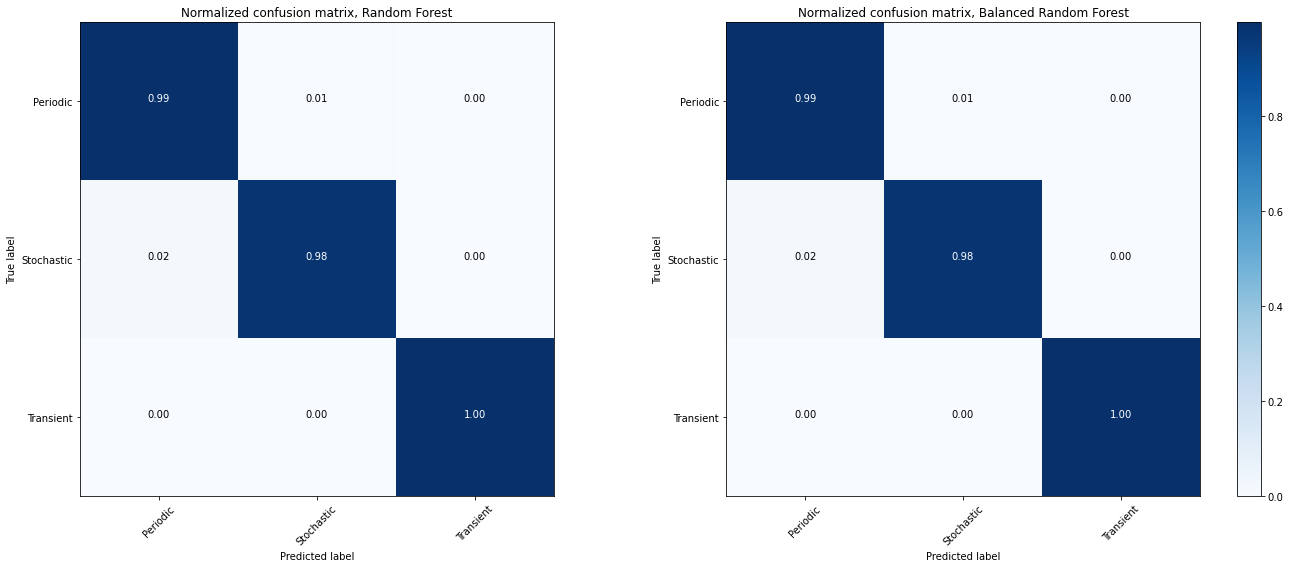

In [417]:
# Plot RF normalized confusion matrix
cnf_matrix = confusion_matrix(y_test_top, y_pred_top)
plt.figure(figsize=(20,8))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test_top), normalize=True,
                      title='Normalized confusion matrix, Random Forest')

# Plot BRF normalized confusion matrix
cnf_matrix = confusion_matrix(y_test_top, y_pred_top)
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test_top), normalize=True,
                      title='Normalized confusion matrix, Balanced Random Forest')

In [466]:
N_val = 100
Ns = np.concatenate([2**np.arange(5, 16), [x_train.shape[0] - N_val -1]])
#Ns = [100, 1000, 10000, x_train.shape[0] - N_val]

print (Ns)
scores = np.zeros(len(Ns))
stds = np.zeros(len(Ns))
for i in range(len(Ns)):
    print (i, Ns[i])
    N = Ns[i]
    ss = model_selection.StratifiedShuffleSplit(n_splits=10, test_size = N_val, train_size = N)
    scores_i = model_selection.cross_val_score(model_top, x_train, y_train, cv=ss)
    scores[i] = scores_i.mean()
    print (i, Ns[i], scores[i])
    stds[i] = scores_i.std()
    


[   32    64   128   256   512  1024  2048  4096  8192 16384 32768 50129]
0 32
0 32 0.34800000000000003
1 64
1 64 0.387
2 128
2 128 0.37100000000000005
3 256
3 256 0.378
4 512
4 512 0.457
5 1024
5 1024 0.6469999999999999
6 2048
6 2048 0.475
7 4096
7 4096 0.601
8 8192
8 8192 0.667
9 16384
9 16384 0.7350000000000001
10 32768
10 32768 0.8100000000000002
11 50129
11 50129 0.8099999999999999


In [470]:
N_val = 100
Ns = np.concatenate([2**np.arange(5, 16), [x_train.shape[0] - N_val -1]])
#Ns = [100, 1000, 10000, x_train.shape[0] - N_val]
accs = []

i_shuffle = np.arange(y_train_top.shape[0])
np.random.shuffle(i_shuffle)

print (Ns)
scores = np.zeros(len(Ns))
stds = np.zeros(len(Ns))
for i in range(len(Ns)):
    model_top = BalancedRandomForestClassifier (
                n_estimators=500,
                max_features='auto',
                max_depth=None,
                n_jobs=-1,
                bootstrap=True,
                class_weight='balanced_subsample',
                criterion='entropy',
                min_samples_split=2,
                min_samples_leaf=1)

    model_top.fit(x_train.values[i_shuffle][:Ns[i]], y_train_top.values[i_shuffle][:Ns[i]])
    y_pred_top = model_top.predict (x_test)

    acc_test = accuracy_score(y_test_top, y_pred_top)
    accs.append(acc_test)
    print (Ns[i], acc_test)

[   32    64   128   256   512  1024  2048  4096  8192 16384 32768 50128]
32 0.8680971659919028
64 0.8775708502024292
128 0.8794331983805668
256 0.9159109311740891
512 0.9433603238866397
1024 0.9570445344129554
2048 0.9664372469635627
4096 0.9771255060728745
8192 0.9824291497975709
16384 0.9862348178137652
32768 0.9878947368421053
50128 0.988582995951417


In [458]:
8**np.arange(2, 10)

array([       64,       512,      4096,     32768,    262144,   2097152,
        16777216, 134217728])

In [461]:
print (Ns, scores, stds)

[100, 1000, 10000, 50129] [0.318 0.47  0.729 0.818] [0.06645299 0.05656854 0.03080584 0.04142463]


<AxesSubplot:title={'center':'Training set'}>

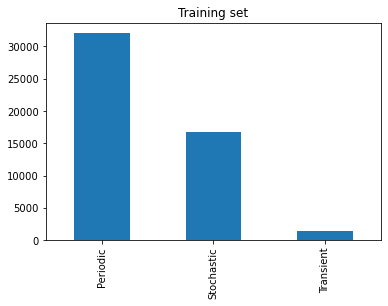

In [463]:
#[100, 1000, 10000, 50129] [0.318 0.47  0.729 0.818] [0.06645299 0.05656854 0.03080584 0.04142463]

df_train_ss['top_label'].value_counts().plot(kind='bar', title = "Training set")

### Comparison with the Recurrent Neural Network

In [464]:
# Results from the RNN
Ns_RNN = [100, 1000, 10000, 56742]
acc_RNN = [0.6733333468437195, 0.7073333263397217, 0.7273333072662354, 0.7646666765213013]

<Figure size 432x288 with 0 Axes>

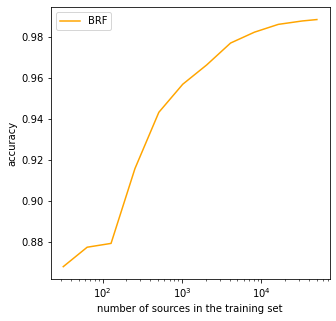

In [478]:
plt.clf()
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(Ns, accs, label = "BRF", c = "orange")
ax.set_xscale("log")
ax.set_xlabel("number of sources in the training set")
ax.set_ylabel("accuracy")
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

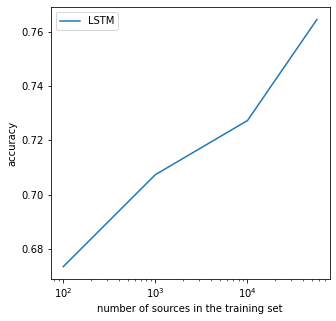

In [479]:
plt.clf()
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(Ns_RNN, acc_RNN, label = "LSTM")
ax.set_xscale("log")
ax.set_xlabel("number of sources in the training set")
ax.set_ylabel("accuracy")
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

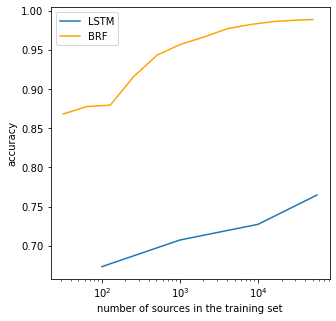

In [480]:
plt.clf()
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(Ns_RNN, acc_RNN, label = "LSTM")
ax.plot(Ns, accs, label = "BRF", c = "orange")
ax.set_xscale("log")
ax.set_xlabel("number of sources in the training set")
ax.set_ylabel("accuracy")
plt.legend()
plt.show()